## Завдання
Використовуючи датасет з файлу cardox.csv (об'єми продажів мережі супермаркетів) виконайте наступну роботу:
1. Проведіть попередній аналіз даних
2. Скорегуйте виявлені аномалії
3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування
ряду, заповнення пропущених значень і. т. і.)
4. Оберіть модель і проведіть оцінку її метрик
5. Проведіть кінцеву діагностику для отриманої моделі
6. Виконайте прогноз на 30 років
7. Збережіть результати прогнозування у файл


In [16]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Завантаження та візуалізація даних.

In [32]:
y = pd.read_csv("cardox.csv", index_col='date')
y.index = pd.to_datetime(y.index)
y.head()

,value
date,
1958-03-01,315.71
1958-04-01,317.45
1958-05-01,317.50
1958-06-01,317.10
1958-07-01,315.86


In [34]:
print(y.shape)
y.info()

(729, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 1958-03-01 to 2018-11-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   729 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


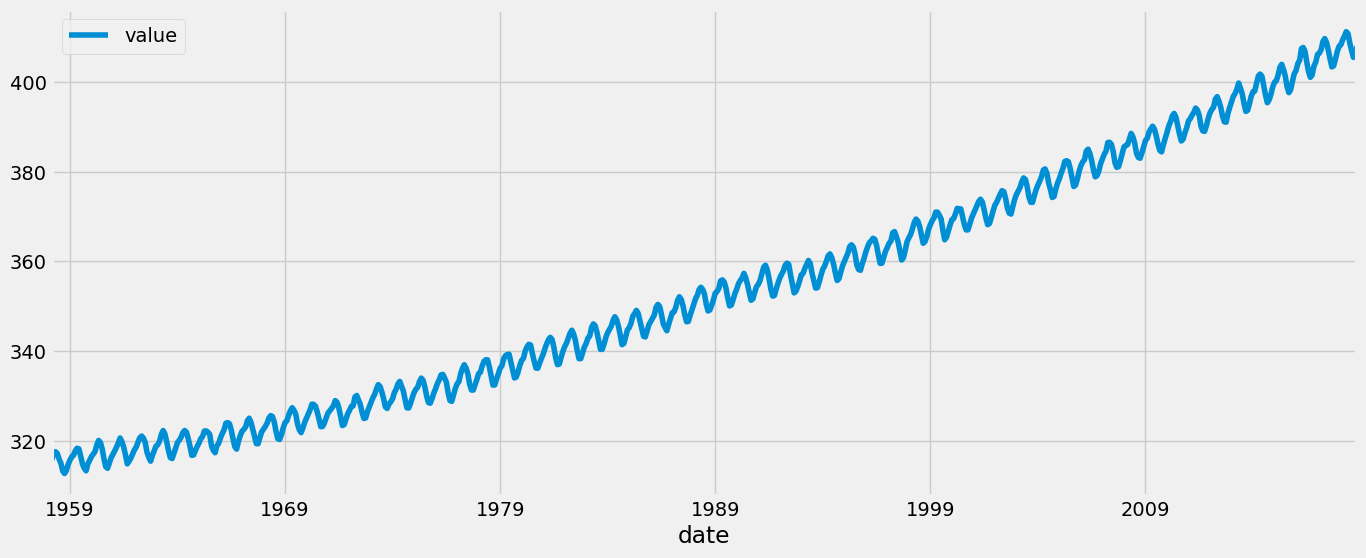

In [18]:
y.plot(figsize=(15, 6))
plt.show()

### Дані мають 1-вимірну структуру, з чітко вираженою сезонністю та зростаючим трендом.
### Скористаємось моделлю SARIMAX.

In [19]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))] 

In [20]:
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
            order=param,
            seasonal_order=param_seasonal,
            enforce_stationarity=False,
            enforce_invertibility=False)
            results = mod.fit()
            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10617.39832828139
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10458.86444824365
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2822.1087284760274
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2377.9596231945015
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1521.8785288720628
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1516.9589115199935
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1864.338786334426
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1357.4062887666573
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9604.771834147392
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8519.19159318147
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2101.36421452541
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1884.3261540899853
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1147.6716492241212
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1140.5843227097334
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1582.5491836318486
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1055.3559187936967
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2371.0019758047247
SARIMAX(0, 1, 0)x(0, 0

In [21]:
mod = sm.tsa.statespace.SARIMAX(y, 
                                order=(1, 1, 1), 
                                seasonal_order=(1, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
results = mod.fit()

In [22]:
results.summary().tables[0]

Dep. Variable:,value,No. Observations:,729
Model:,"SARIMAX(1, 1, 1)x(1, 1, 1, 12)",Log Likelihood,-172.595
Date:,"Fri, 10 Mar 2023",AIC,355.190
Time:,18:36:35,BIC,377.959
Sample:,03-01-1958,HQIC,363.990
,- 11-01-2018,,
Covariance Type:,opg,,


In [23]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.1706,0.084,2.038,0.042,0.007,0.335
ma.L1,-0.5360,0.073,-7.307,0.000,-0.680,-0.392
ar.S.L12,-0.0005,0.000,-1.624,0.104,-0.001,9.83e-05
ma.S.L12,-0.8671,0.021,-41.954,0.000,-0.908,-0.827
sigma2,0.0941,0.005,20.328,0.000,0.085,0.103


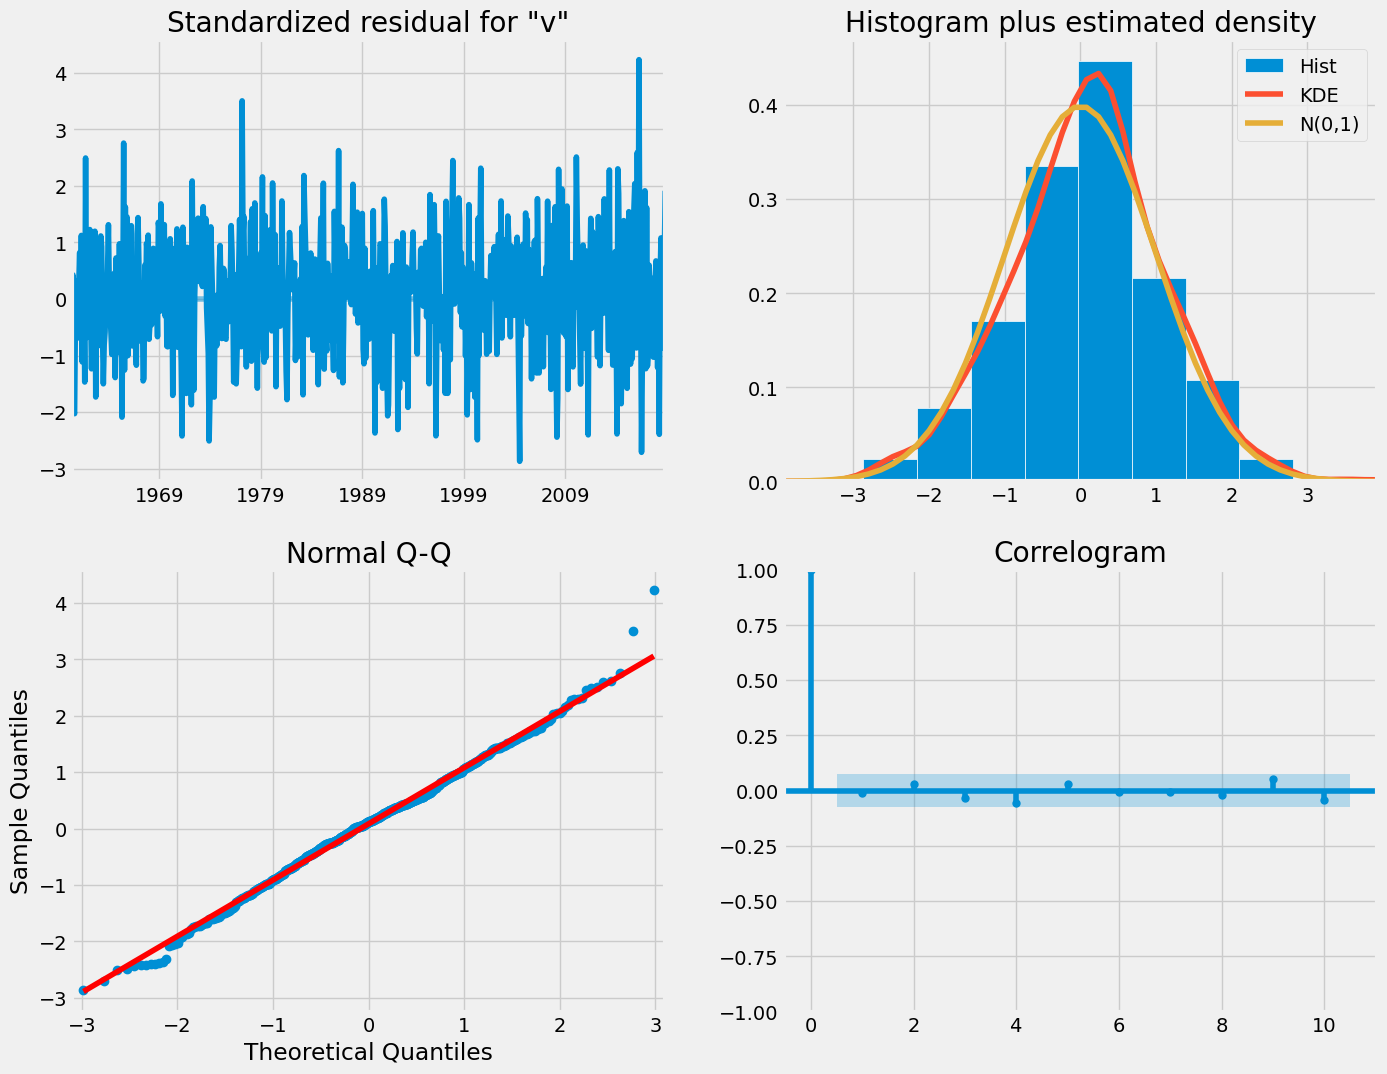

In [24]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [25]:
pred = results.get_prediction(start=pd.to_datetime('2003-01-01'), dynamic=False)

y_forecasted = pred.predicted_mean
y_truth = y['2003-01-01':]
y_truth = pd.Series(y_truth.value)
mse = ((y_forecasted - y_truth) ** 2).mean()

print('Середня квадратична похибка прогнозів = {}'.format(round(mse, 2)))

Середня квадратична похибка прогнозів = 0.11


### Збудована модель має прийнятні показники mse та p-value. Як видно з графіків вище, розподіл плотності - нормальний. Точки нормального графіка Q-Q майже співпадають з прямою, що свідчить про одновимірну нормальність набору даних.

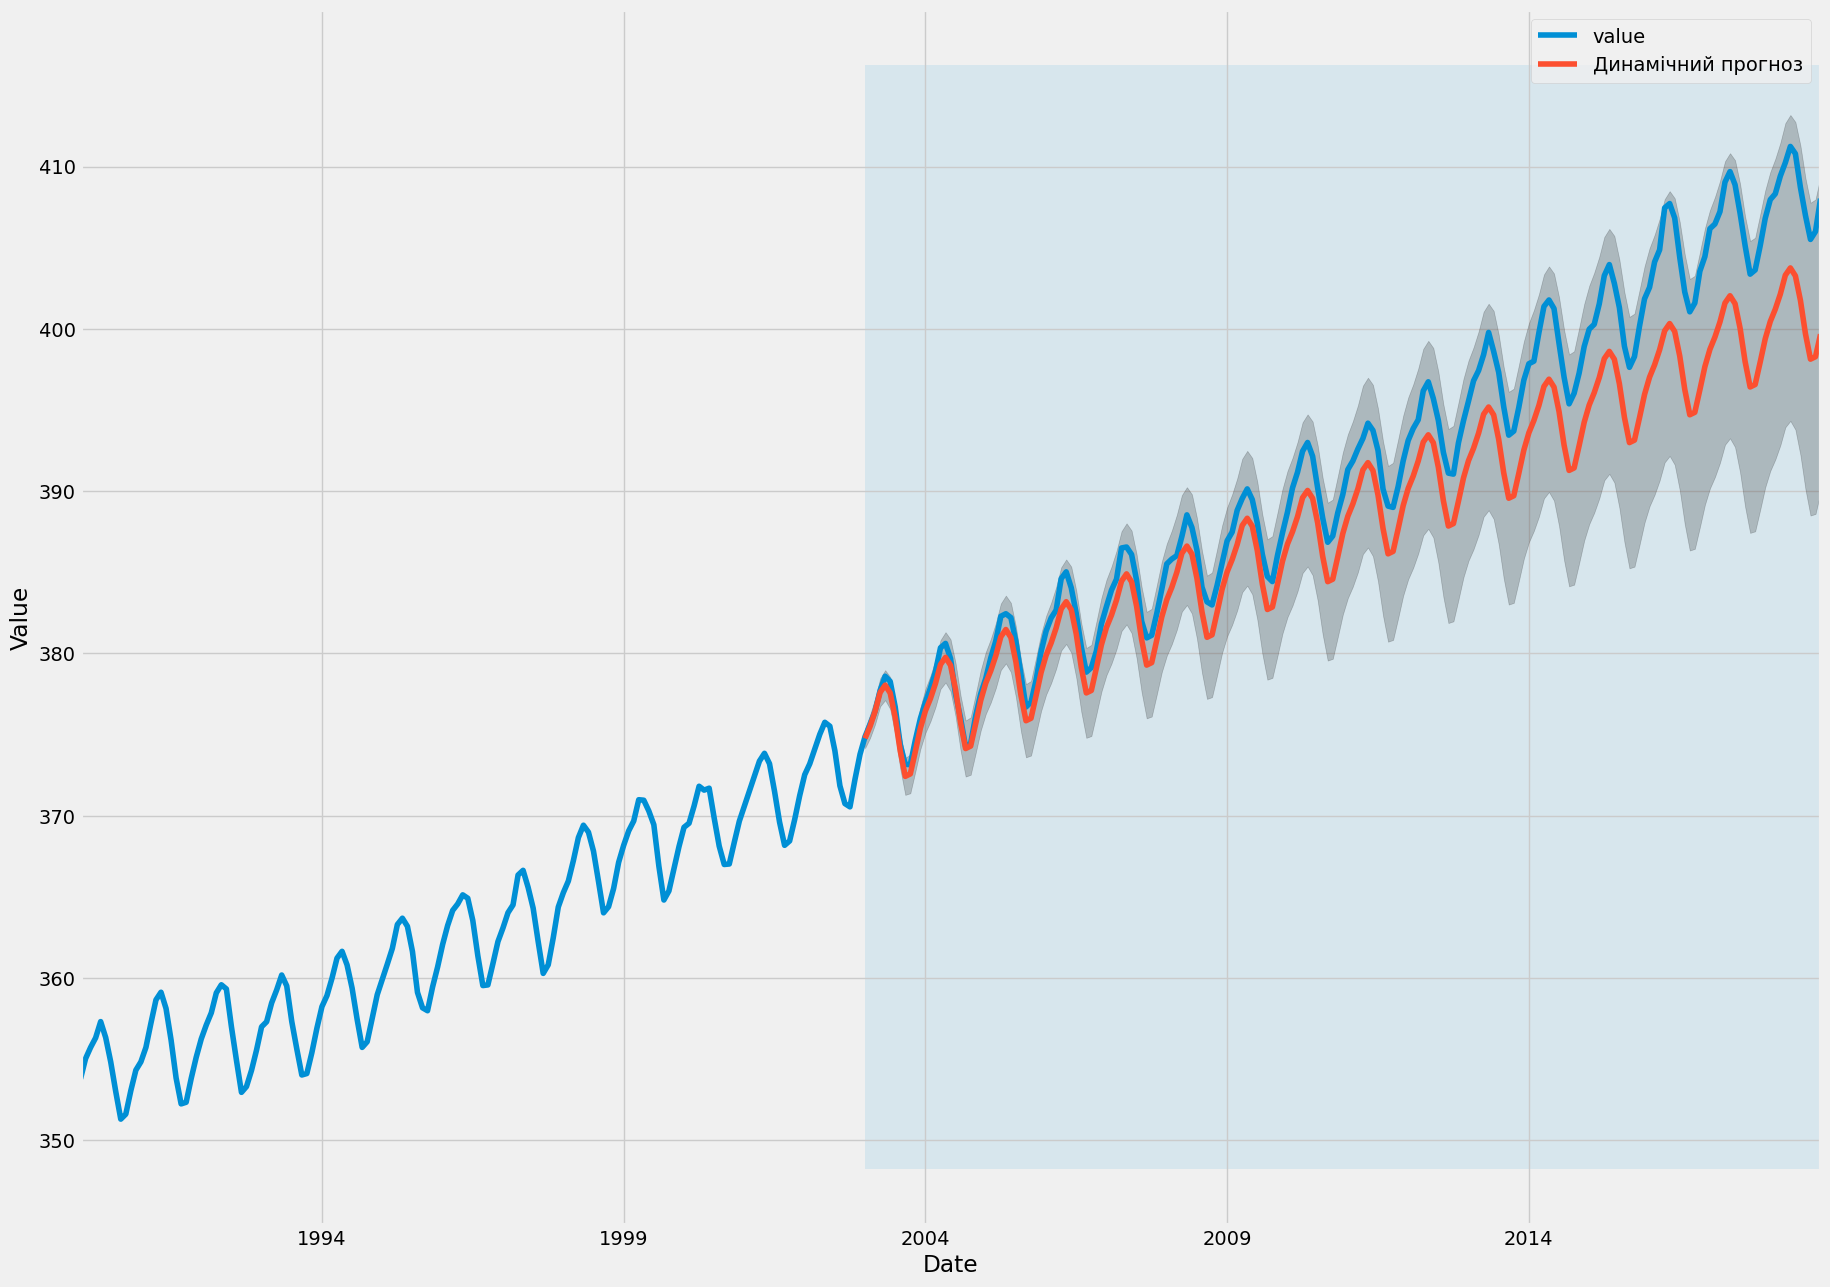

In [30]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2003-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y['1990':].plot(label='Відомі', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Динамічний прогноз', ax=ax)
ax.fill_between(pred_dynamic_ci.index, 
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1],
                color='k', alpha=.2)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2003-01-01'), y.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [27]:
pred_uc = results.get_forecast(steps=360)
pred_ci = pred_uc.conf_int()
pred_ci.head()

,lower value,upper value
2018-12-01,408.650804,409.853057
2019-01-01,409.697743,411.121697
2019-02-01,410.308772,411.890264
2019-03-01,411.170080,412.889718
2019-04-01,412.568892,414.415577


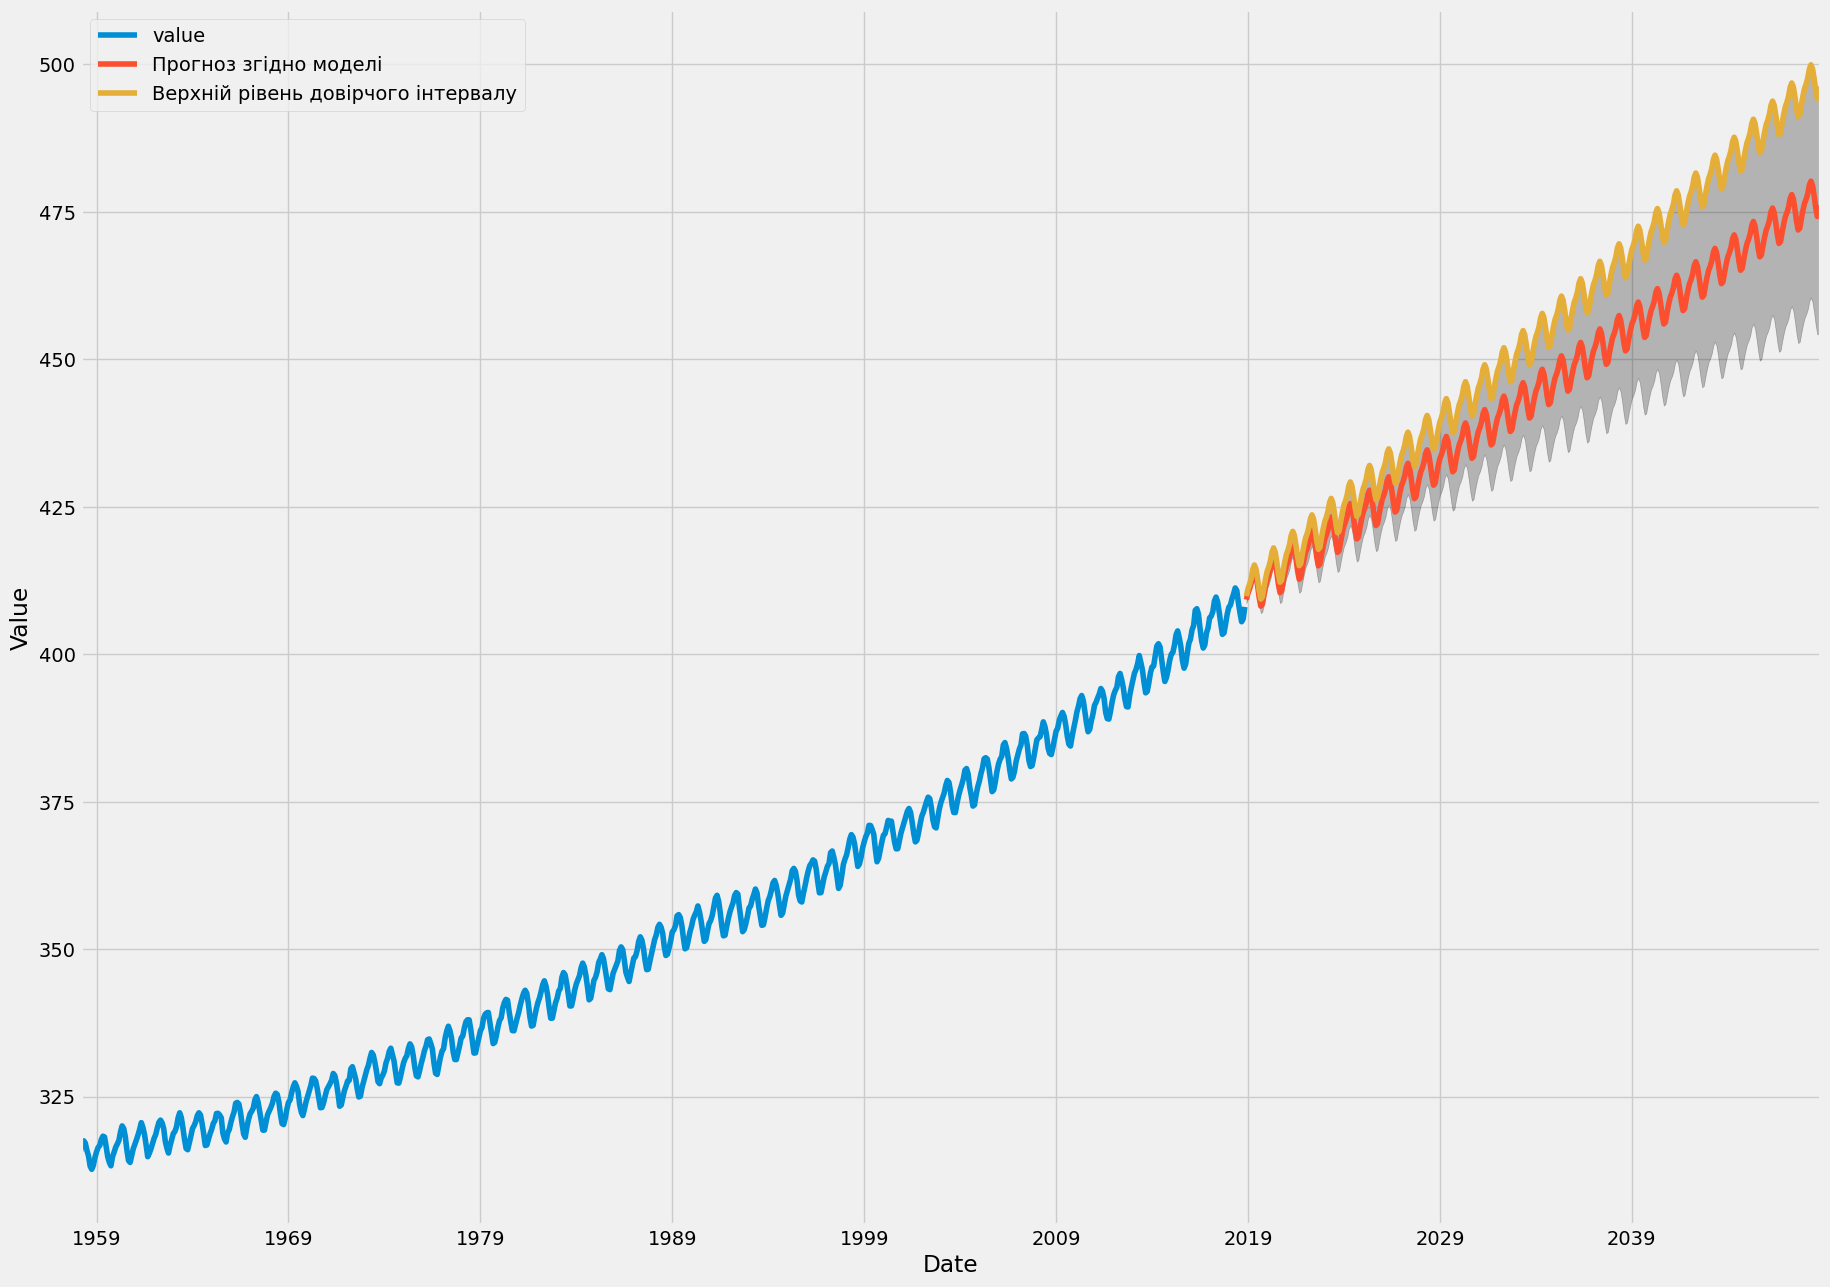

In [28]:
ax = y.plot(label='Відомі', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз згідно моделі')
pred_ci['upper value'].plot(label='Верхній рівень довірчого інтервалу', ax=ax)

ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
plt.show()

In [29]:
pred = pd.DataFrame(pred_uc.predicted_mean)
prediction = pd.concat([pred, pred_ci], axis=1)
prediction.to_csv('prediction_30Y.csv')
prediction.head()

,predicted_mean,lower value,upper value
2018-12-01,409.251930,408.650804,409.853057
2019-01-01,410.409720,409.697743,411.121697
2019-02-01,411.099518,410.308772,411.890264
2019-03-01,412.029899,411.170080,412.889718
2019-04-01,413.492234,412.568892,414.415577


### На тестовому інтервалі (15 років) наша прогнозна крива відхиляється вниз від реальних значень.
### Тобто збудована модель може використовуватись для короткострокових прогнозів, але на довгий строк ймовірно дасть значне відхилення.
### Також можна спостерігати, що верхня границя довірчого інтервалу наближається до реальних значень.
### Тому для цілей довгострокового прогнозу можливо використати верхні значення довірчого інтервалу.